In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid, solve_ivp
from scipy.interpolate import interp1d

<p align="center">
  <img src="https://github.com/marcus-valmeida/Projeto-conversao/blob/medupl/circuito_exercicio2.png?raw=true" alt="Circuito Exercício 1" width="500"/>
</p>

In [2]:
#Dados da questão
R = 4*1e-2
D = 15*1e-2
N1  = 90
lc = 25*1e-2
U0  = 4*np.pi*1e-7
alpha  = np.pi / 3
g = 2*1e-3
num_pontos = 200

#caso real
CampoMagnetico = np.array([0, 68, 135, 203, 271, 338, 406, 474, 542, 609, 1100, 1500, 2500, 4000, 5000, 9000, 12000, 20000, 25000])
DensidadeCampo = np.array([0, 0.733, 1.205, 1.424, 1.517, 1.560, 1.588, 1.617, 1.631, 1.646, 1.689, 1.703,1.724, 1.731, 1.738, 1.761, 1.770, 1.800, 1.816])

#caso linear
CampoMagnetico_linear = np.array([0, 68])
DensidadeCampo_linear = np.array([0, 0.733])

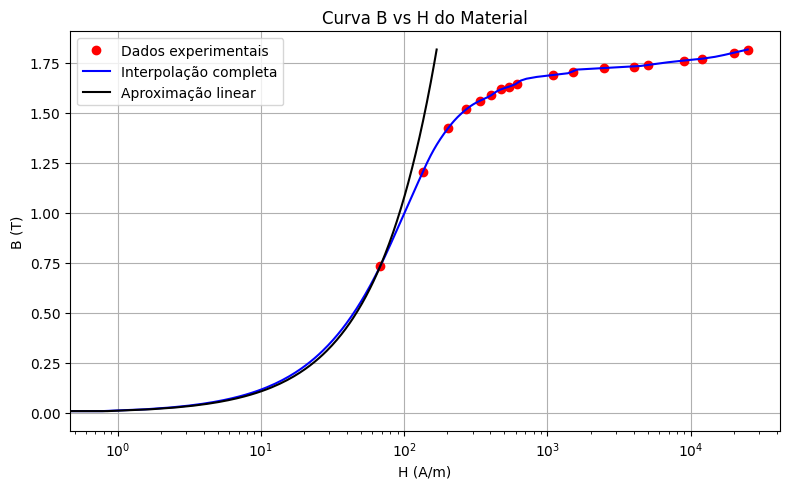

In [3]:
# Interpolação cúbica (ordem crescente de B)
f_real = CubicSpline(DensidadeCampo, CampoMagnetico, bc_type='natural')
f_linear = CubicSpline(DensidadeCampo_linear, CampoMagnetico_linear, bc_type='natural')

# Geração de pontos para interpolação
B_a = np.linspace(min(DensidadeCampo), max(DensidadeCampo), num_pontos)
H_a = f_real(B_a)
H_linear_a = f_linear(B_a)

# Plotagem
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(CampoMagnetico, DensidadeCampo, 'ro', label='Dados experimentais')
ax.plot(H_a, B_a, 'b-', label='Interpolação completa')
ax.plot(H_linear_a, B_a, 'k-', label='Aproximação linear')

ax.set_title('Curva B vs H do Material')
ax.set_xlabel('H (A/m)')
ax.set_ylabel('B (T)')
ax.set_xscale('log')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

#### Considere que o controlador do sistema aplica corrente em apenas uma bobina de cada vez.

- Apresente um gráfico do fluxo concatenado na bobina 1 em função da corrente aplicada nessa bobina considerando a posição do rotor variando da posição 0° até 60°.
    - Observação: seu gráfico terá uma curva de fluxo em função da corrente para cada posição. Se
você fizer o plot para todas as posições que calcular, a figura fica sobre carregada. Sugiro
fazer o plot com cerca de 10 posições diferentes ( ou seja, 0, 6, 12... 60°).

In [4]:
def area_eficaz(theta):

    #limitando de 0 a 360 graus
    theta = np.mod(theta, np.pi)

    #0 até 30 graus
    if (0 <= theta <= np.pi/6):
        return R * D * (np.pi/3 - theta)
    
    #30 até 60 graus ou 120 até 150 graus
    elif (np.pi/6 < theta <= np.pi/3) or (2*np.pi/3 < theta <= 5*np.pi/6):
        return R * D * (np.pi/6)
    
    #150 até 180 graus
    elif (5*np.pi/6 < theta <= np.pi):
        return R * D * (theta - 2*np.pi/3)
    
    else :
        return 0

def fluxo_concatenado(area, corrente, B, operacao, Interpolacao_H_B):

    # Inicialmente iremos calcular a relutância do circuito magnético
    relutancia = np.inf if area == 0 else (2*g)/(U0 * area)

    # Agora podemos calcular o fluxo magnético
    if operacao == "real":

        if area == 0:
            fluxo = 0
            corrente = 0

        else:
            # Como o fluxo no núcleo é o mesmo, e a área dos polos são iguais temos que B0 = B
            B0 = B
            
            # Calcula a intensidade de campo magnético (H) no entreferro (H = B / μ0)
            H0 = B0 / U0

            # Aplica a Lei de Hopkinson para encontrar a corrente necessária
            # Soma (MMF do núcleo + MMF do entreferro) e divide pelo número de espiras
            corrente = (Interpolacao_H_B(B) * lc + 2 * H0 * g) / N1
            
            # Calcula o fluxo concatenado (λ = N * B * A)
            fluxo = B * area * N1 
    
    elif operacao == "linear":
        ## Modelo linear: a relutância é constante, e o fluxo é diretamente proporcional à corrente.
        fluxo = 0 if relutancia == np.inf else ((N1**2) * corrente) / relutancia

    return fluxo, corrente

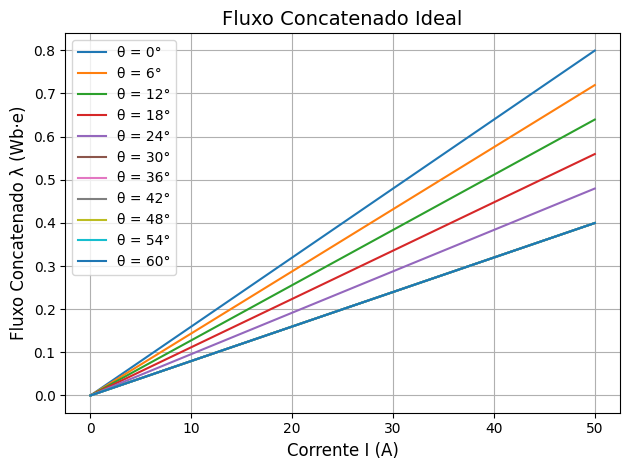

In [5]:
# Dados para o Fluxo Concatenado Ideal
correntes_linear = np.linspace(0, 50, 300)
angulos_deg = np.linspace(0, 60, 11)
angulos_rad = np.radians(angulos_deg)

Interpolacao_H_B = interp1d(DensidadeCampo, CampoMagnetico, kind='linear', fill_value='extrapolate')

plt.figure()
for theta in angulos_rad:
    area = area_eficaz(theta)
    
    # Gera a lista de fluxos ideal para o ângulo atual
    fluxos_ideal = [fluxo_concatenado(area, i, 0.733, "linear", Interpolacao_H_B)[0] for i in correntes_linear]

    plt.plot(correntes_linear, fluxos_ideal, label=f'θ = {np.degrees(theta):.0f}°')

plt.title('Fluxo Concatenado Ideal', fontsize=14)
plt.xlabel('Corrente I (A)', fontsize=12)
plt.ylabel('Fluxo Concatenado λ (Wb·e)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




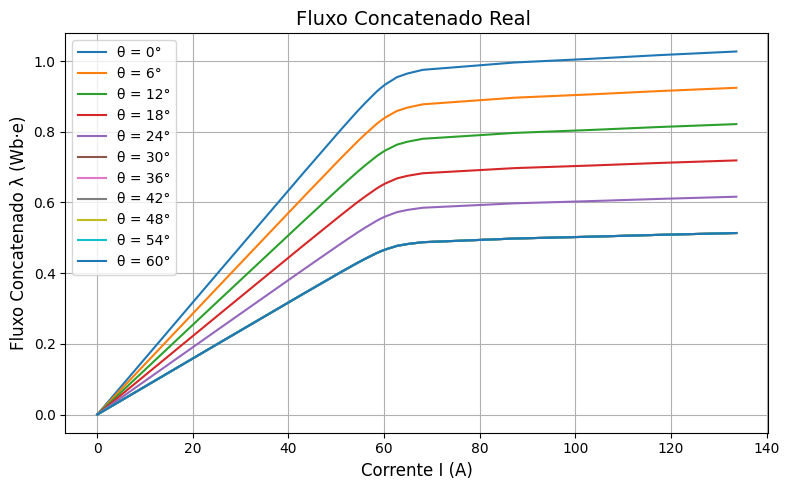

In [6]:
# Dados para o Fluxo Concatenado Real
densidade_campo_real = np.linspace(min(DensidadeCampo), max(DensidadeCampo), 100)

plt.figure(figsize=(8,5))
for theta in angulos_rad:
    area = area_eficaz(theta)
    if area == 0:
        continue
    
    # Gera as listas de fluxos e correntes para o ângulo atual
    fluxo_corrente_real = [fluxo_concatenado(area, None, B, "real", Interpolacao_H_B) for B in densidade_campo_real]
    
    fluxos_reais = [item[0] for item in fluxo_corrente_real]
    correntes_reais = [item[1] for item in fluxo_corrente_real]

    plt.plot(correntes_reais, fluxos_reais, label=f'θ = {np.degrees(theta):.0f}°')

plt.title('Fluxo Concatenado Real ', fontsize=14)
plt.xlabel('Corrente I (A)', fontsize=12)
plt.ylabel('Fluxo Concatenado λ (Wb·e)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

- Determine qual deve ser a corrente aplicada na bobina de modo a obter uma
densidade de fluxo de 1,8 T quando o rotor estiver na posição zero graus.

In [7]:
# Precisamos achar a corrente que gera 1.8T no entreferro
B = 1.8                                             # Densidade de fluxo magnético no entreferro dado na questão

H_nucleo = f_real(B)                                # Campo magnético no núcleo a partir da interpolação
H_entreferro = B / U0                               # Campo magnético no entreferro (H = B / μ0)

# Calculando a corrente aplicada
corrente_real = (H_nucleo * lc + 2 * H_entreferro * g) / N1

# No modelo ideal, o material do núcleo é considerado perfeito e não apresenta relutância.
# Consequentemente, a intensidade de campo magnético (H) necessária no núcleo é zero (Hnuc =0)
corrente_ideal = (2 * H_entreferro * g) / N1

print(f"A corrente aplicada necessária para gerar {B}T no entreferro é: {corrente_real:.4f} A")
print(f"A corrente ideal necessária para gerar {B}T no entreferro é: {corrente_ideal:.4f} A")

A corrente aplicada necessária para gerar 1.8T no entreferro é: 119.2175 A
A corrente ideal necessária para gerar 1.8T no entreferro é: 63.6620 A


#### Considere que a corrente calculada no item anterior é aplicada na bobina 1.

- Apresente um gráfico do Torque produzido pela bobina 1 em função da posição do rotor considerando que o núcleo seja ideal;

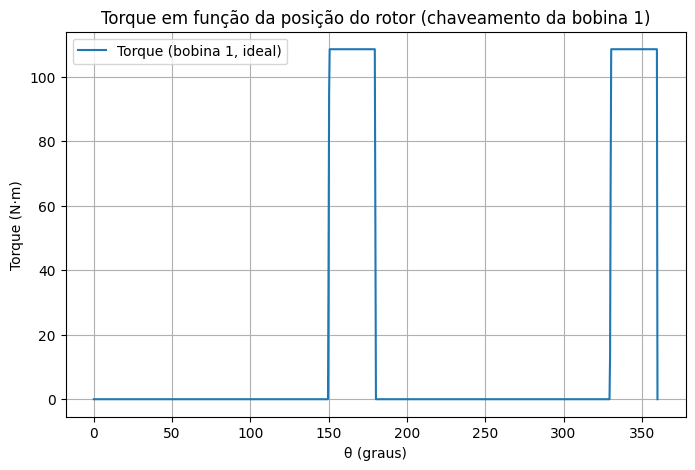

In [8]:
# Para um núcleo ideal, o torque (T) é gerado pela mudança na indutância (L) da bobina com o ângulo de rotação (θ).
# A relação é dada por T = k * I² * (dL/dθ), onde k é uma constante de proporcionalidade. k = 0.5

angulo_graus = np.linspace (0,360,1000)
angulo_rad = np.radians(angulo_graus)
L = np.zeros_like(angulo_rad)

for i, theta in enumerate(angulo_rad):
    L[i] = (N1**2 * U0 * area_eficaz(theta)) / (2*g)            # Indutância L = N^2 / Relutância

# Encontrando a derivada (dL/dθ)
derivada_L = np.gradient(L, angulo_rad)

def corrente_bobina1(theta):
    theta_deg = np.degrees(theta) % 360

    # Liga entre 120° e 180°
    if 120 <= theta_deg < 180:
        # Cresce linearmente de 0 até I_des nesse intervalo
        return corrente_real

    # Liga entre 300° e 360°
    elif 300 <= theta_deg < 360:
        return corrente_real

    else:
        return 0

torque_chaveado = []
for t, dLdt in zip(angulo_rad, derivada_L):
    I_t = corrente_bobina1(t)
    # Zera torque nos pontos de chaveamento (120° e 300°)
    theta = (np.degrees(t) % 360)
    if np.isclose(theta, 120, atol=0.5) or np.isclose(theta, 300, atol=0.5):
        torque_chaveado.append(0.0)
    else:
        torque_chaveado.append(0.5 * (I_t**2) * dLdt)

torque_chaveado = np.array(torque_chaveado)

plt.figure(figsize=(8,5))
plt.plot(angulo_graus, torque_chaveado, label="Torque (bobina 1, ideal)")
plt.xlabel('θ (graus)'); plt.ylabel('Torque (N·m)')
plt.title('Torque em função da posição do rotor (chaveamento da bobina 1)')
plt.grid(True)
plt.legend()
plt.show()

- Topico 4
- Apresente um gráfico do Torque produzido pela bobina 1 em função
da posição do rotor considerando a característica real do núcleo;


In [9]:
# topico 4

#### Considere que a máquina está girando com uma velocidade constante em sentido anti-horário.

- Topico 5
- Apresente um gráfico do valor eficaz do torque produzido pela
máquina em função da corrente aplicada nas bobinas considerando o
núcleo ideal;

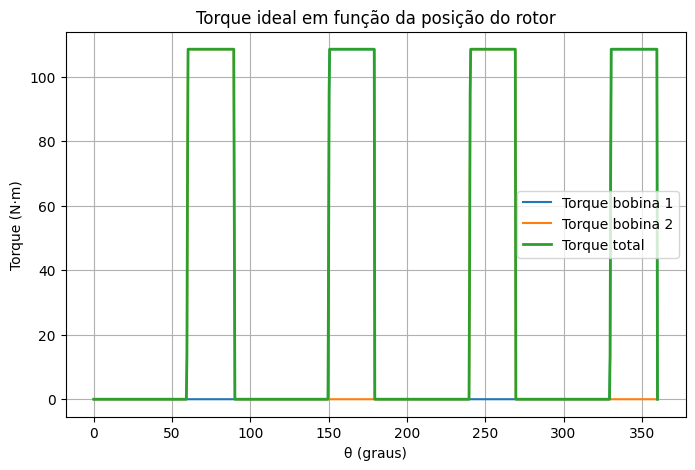

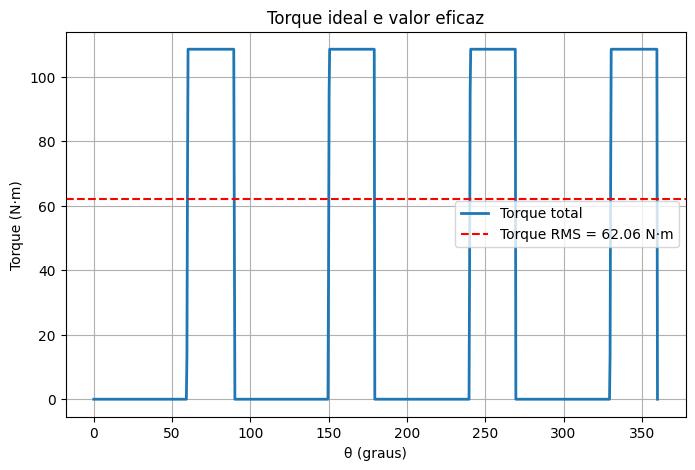

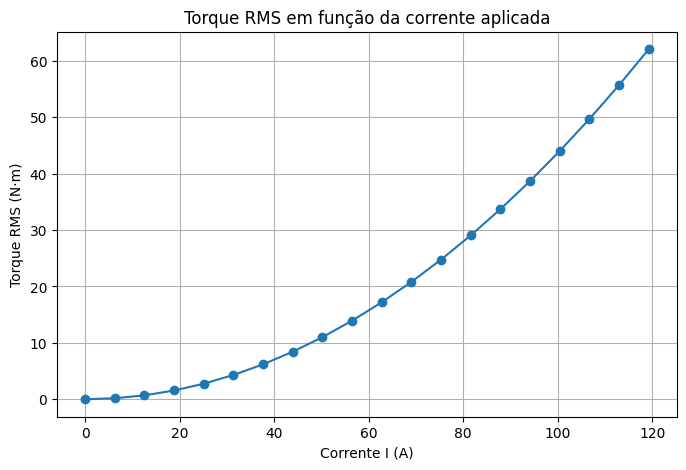

In [10]:
def corrente_bobina2(theta):
    ang = np.degrees(theta)
    ang_mod = ang % 360
    ativa = ((30 <= ang_mod < 90) or (210 <= ang_mod < 270))
    return corrente_real if ativa else 0

#Área eficaz da bobina 2
def area_eficaz_2(theta):
    #limitando de 0 a 180 graus
    theta = np.mod(theta, np.pi)


    if (0<= theta <np.pi/6):
        return 0


    elif (np.pi/6< theta <=np.pi/3):
        return D*R*np.pi/6


    elif (np.pi/3< theta <=np.pi/2):
        return D*R*(theta - np.pi/6)


    elif (np.pi/2< theta <= 2*np.pi/3):
        return D*R*(5*np.pi/6 - theta)


    elif (2*np.pi/3 < theta <5*np.pi/6):
        return D*R*np.pi/6


    elif (5*np.pi/6 < theta <np.pi):
        return 0
    else:
        return 0

def shift_array(arr, shift_rad, theta_array):
    shift = shift_rad / (theta_array[1] - theta_array[0])
    return np.roll(arr, int(np.round(shift)))


# --- Correntes em função de θ ---
I1_theta = np.array([corrente_bobina1(t) for t in angulo_rad])
I2_theta = np.array([corrente_bobina2(t) for t in angulo_rad])

# --- Indutâncias ---
L11 = np.array([(N1**2 * U0 * area_eficaz(t)) / (2 * g) for t in angulo_rad])
L22 = shift_array(L11, np.pi/2, angulo_rad)

# --- Derivadas das indutâncias ---
dL11_dtheta = np.gradient(L11, angulo_rad)
dL22_dtheta = np.gradient(L22, angulo_rad)

# --- Torques de cada bobina ---
torque_1 = 0.5 * (I1_theta**2) * dL11_dtheta
torque_2 = 0.5 * (I2_theta**2) * dL22_dtheta

# --- Torque total ---
torque_total = torque_1 + torque_2

# --- Zera torque nos pontos de comutação para remover picos ---
bounds_deg = np.array([120, 180, 210, 270, 300, 360])  # pontos de chaveamento
tol = max(0.5, (angulo_graus[1] - angulo_graus[0]) * 2)  # tolerância em graus
for b in bounds_deg:
    idx = np.where(np.isclose(angulo_graus % 360, b % 360, atol=tol))[0]
    torque_1[idx] = 0.0
    torque_2[idx] = 0.0
    torque_total[idx] = 0.0

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(angulo_graus, torque_1, label="Torque bobina 1")
plt.plot(angulo_graus, torque_2, label="Torque bobina 2")
plt.plot(angulo_graus, torque_total, label="Torque total", linewidth=2)
plt.xlabel('θ (graus)')
plt.ylabel('Torque (N·m)')
plt.title('Torque ideal em função da posição do rotor')
plt.grid(True)
plt.legend()
plt.show()

# --- cálculo do RMS do torque total (uma volta completa) ---
torque_total_squared = torque_total**2
T_rms = np.sqrt(trapezoid(torque_total_squared, angulo_rad) / (angulo_rad[-1] - angulo_rad[0]))

# --- plot com linha horizontal indicando o RMS ---
plt.figure(figsize=(8,5))
plt.plot(angulo_graus, torque_total, label="Torque total", linewidth=2)
plt.axhline(T_rms, color='red', linestyle='--', label=f"Torque RMS = {T_rms:.2f} N·m")
plt.xlabel("θ (graus)")
plt.ylabel("Torque (N·m)")
plt.title("Torque ideal e valor eficaz")
plt.grid(True)
plt.legend()
plt.show()

#Definição das correntes a avaliar
correntes_rms = np.linspace(0, corrente_real, 20)  # 20 valores de corrente de 0 a I_des
torques_rms = []

for I in correntes_rms:
    # Escala as correntes das bobinas
    I1_theta_scaled = I1_theta * (I / corrente_real)
    I2_theta_scaled = I2_theta * (I / corrente_real)


    # Recalcula o torque com as correntes escaladas
    torque_1_scaled = 0.5 * (I1_theta_scaled**2) * dL11_dtheta
    torque_2_scaled = 0.5 * (I2_theta_scaled**2) * dL22_dtheta
    torque_total_scaled = torque_1_scaled + torque_2_scaled

    # Zera torque nos pontos de chaveamento (mesma lógica que antes)
    for b in bounds_deg:
        idx = np.where(np.isclose(angulo_graus % 360, b % 360, atol=tol))[0]
        torque_total_scaled[idx] = 0.0

    # Calcula torque RMS
    torque_total_squared = torque_total_scaled**2
    T_rms = np.sqrt(trapezoid(torque_total_squared, angulo_rad) / (angulo_rad[-1] - angulo_rad[0]))
    torques_rms.append(T_rms)

# --- Plot Torque RMS vs Corrente ---
plt.figure(figsize=(8,5))
plt.plot(correntes_rms, torques_rms, marker='o')
plt.xlabel('Corrente I (A)')
plt.ylabel('Torque RMS (N·m)')
plt.title('Torque RMS em função da corrente aplicada')
plt.grid(True)
plt.show()

- Topico 6
- Apresente um gráfico do valor eficaz do torque produzido pela
máquina em função da corrente aplicada nas bobinas considerando a
característica real do núcleo;


In [12]:
# Topico 6

- Topico 7
- Deseja-se que o sistema opere com uma velocidade constante de 100 RPM em
sentido anti-horário. Descreva como o controlador deverá aplicar corrente nas
bobinas de modo a alcançar essa velocidade.

In [ ]:
# Topico 7

- Topico 8
- Nessas condições, considerando o núcleo como sendo ideal, determine a razão
entre a potência mecânica desenvolvida pelo motor e a potência necessária para
o sistema de acionamento

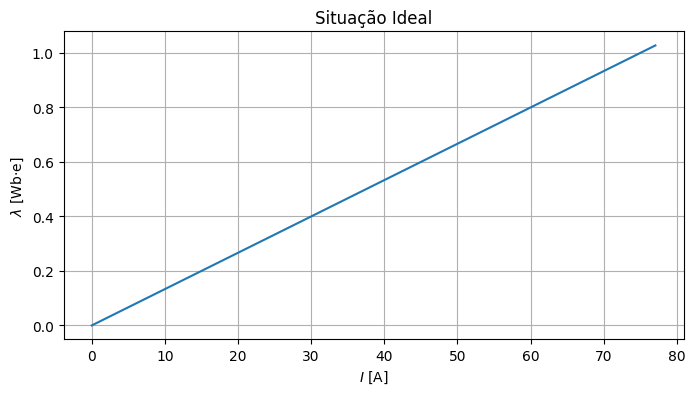

θ = 0°: Razão = 74.34%
θ = 12°: Razão = 71.73%
θ = 24°: Razão = 68.43%
θ = 36°: Razão = 66.44%
θ = 48°: Razão = 66.44%
θ = 60°: Razão = 66.44%


In [11]:
Ac = area_eficaz(0)
fluxo = N1 * DensidadeCampo * Ac

# Ideal para 10°
B_g = (DensidadeCampo * Ac) / max(area_eficaz(np.pi/18), 1e-12)
I_ideal = (B_g * 2 * g / U0) / N1

plt.figure(figsize=(8,4))
plt.plot(I_ideal, fluxo)
plt.title("Situação Ideal"); plt.ylabel(r"$\lambda$ [Wb·e]"); plt.xlabel(r"$I$ [A]")
plt.grid(True); plt.show()

# Razão P_motor/P_ac para 0-60°
for ang in np.radians([0, 12, 24, 36, 48, 60]):
    Aang = area_eficaz(ang)
    B_g = (DensidadeCampo * Ac) / Aang if Aang != 0 else 0

    I_real = (CampoMagnetico*lc + B_g*2*g/U0) / N1
    order = np.argsort(I_real)
    I_sort, lam_sort = I_real[order], fluxo[order]

    I_uniq, idx = np.unique(I_sort, return_index=True)
    lam_uniq = lam_sort[idx]

    if len(I_uniq) > 1:
        Wc = trapezoid(lam_uniq, I_uniq)
        Wf = trapezoid(I_uniq, lam_uniq)
        razao = Wc / (Wf + Wc)
    else:
        razao = 0

    print(f"θ = {np.degrees(ang):.0f}°: Razão = {razao:.2%}")

- Topico 9
- Nessas condições, considerando a característica real do núcleo, determine a
razão entre a potência mecânica desenvolvida pelo motor e a potência
necessária para o sistema de acionamento.

In [13]:
# Topico 9